# Plotting Fig 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics

import warnings
import matplotlib as mpl
import plot_utils

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Load Data

In [5]:
def read_mice_subset(is_educated, normalization='AS'):
    if is_educated:
        path_in = '../data/Affinity_prediction_educated_repertoire.xlsx'
    else:
        path_in = '../data/Affinity_prediction_naive_repertoire.xlsx'
    if normalization == 'AS':
        df = pd.read_excel(path_in, 'Normalized data', skiprows=1)
    else:
        df = pd.read_excel(path_in, 'Individual APL screening', skiprows=1)
    #columns = df.columns
    #tcrs = columns[::4]
    #columns = columns[3::4]
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df_pos = pd.read_excel(path_in, 'Individual APL screening', skiprows=1)
    df_pos.loc[152, 'Position'] = 0
    df['Mutated_position'] = df_pos['Position']
    df = df.drop(columns=['Sequence', 'Amino Acid', 'Position', 'APL'], errors='ignore')
    return df

In [6]:
def read_mice_data(normalization='AS'):
    data_naive = read_mice_subset(False, normalization=normalization)
    data_educated = read_mice_subset(True, normalization=normalization)
    
    data_joint = pd.concat([data_naive, data_educated], axis=1, join='inner')
    order = list(data_joint.columns)
    order.remove('OTI')
    order = ['OTI'] + [x for x in order if x.startswith('Ed')] + [x for x in order if not x.startswith('Ed')]
    data_joint = data_joint[order]
    data_joint.index = [f'{i//19 + 1}_{i%19}' for i in range(len(data_joint))]
    data_joint = data_joint.rename(index={'9_0': '0_0'})
    
    data_joint = data_joint[[col for col in data_joint.columns if col != 'Mutated_position']]
    return data_joint

### Mice Data

In [7]:
data_mice_norm = read_mice_data(normalization='AS')
data_mice_unnorm = read_mice_data(normalization='None')

### Human Data

In [8]:
def read_human_data(normalization='pc'):
    path_in = '../data/Affinity_prediction_rnf43_repertoire.xlsx'
    sheet = 'Normalized by PC'
    if normalization != 'pc':
        sheet = 'Individual APL screening'
    df = pd.read_excel(path_in, sheet)
    df['Mutated_position'] = df['Mutated_position'].replace({'VPSVWRSSL': 0})
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df.index = df['Mutated_position'].astype(str) + '_' + df['Mutated AA'].astype(str)
    df = df.drop(columns=['Peptide', 'Mutated_position', 'Peptide ID', 'Mutated AA'])
    #tcrs = df.columns[4:11]
    #df = df[tcrs]
    df = df.drop(['R27'], axis=1)
    df = df.reindex(df.index[1:].tolist() + df.index[:1].tolist())
    return df

In [9]:
data_human_norm = read_human_data(normalization='pc')
data_human_unnorm = read_human_data(normalization='none')

In [10]:
data_mice_norm.columns

Index(['OTI', 'Ed5', 'Ed8', 'Ed9', 'Ed10', 'Ed16-1', 'Ed16-30', 'Ed21', 'Ed23',
       'Ed28', 'Ed31', 'Ed33', 'Ed39', 'Ed40', 'Ed45', 'Ed46', 'B11', 'B15',
       'B3', 'F4', 'E8', 'B13', 'H6', 'G6', 'F5', 'H5', 'B2', 'B6', 'B5', 'E9',
       'E4', 'G2', 'B16', 'B14', 'B7', 'B10'],
      dtype='object')

## Colors

In [11]:
palette_tcrs = {'OTI': 'tab:green',
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick'
               }
palette_tcrs_cmap = mpl.colors.ListedColormap(list(palette_tcrs.values()))

cmap_positions = mpl.colors.ListedColormap(['silver'] + sb.color_palette('Purples', 12)[3:])

cmap_heatmap = 'rocket'

color_base ='silver'
color_thresh = 'silver'
style_base = ':'
style_thresh = '--'

In [12]:
def tcr_2_color(tcr, color=True):
    if tcr.startswith('R'):
        return palette_tcrs['Human'] if color else 3
    if tcr == 'OTI':
        return palette_tcrs['OTI'] if color else 0
    if tcr.startswith('Ed'):
        return palette_tcrs['Educated'] if color else 1
    return palette_tcrs['Naive'] if color else 2

## Plotting functions

In [13]:
def plot_activation_heatmap(data, gs_full, fig, yscale=1):
    data = data.transpose()       
    gs_12 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_full,
                                              nrows=2, ncols=1, 
                                              height_ratios=[0.03*yscale+1, 0.05*yscale],
                                              hspace=0.05*yscale)
    
    gs = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[0],
                                              nrows=2, ncols=2, 
                                              width_ratios=[0.03, 1], height_ratios=[0.03*yscale, 1],
                                              wspace=0.01, hspace=0.01*yscale)
    
    cbar_width = 0.75
    gs_3 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[1],
                                              nrows=1, ncols=4, 
                                              width_ratios=[0.03, (1-cbar_width)/2, cbar_width, (1-cbar_width)/2],
                                              wspace=0.01)

    # tcr color code
    ax_rowcolors = fig.add_subplot(gs[2])
    tcr_colors = np.array([tcr_2_color(tcr, color=False) for tcr in data.index]).reshape((-1, 1))

    tcrs_selected = ['ED21', 'ED28', 'ED39', 'B11', 'G6', 'E8', 'ED8', 'ED5', 'F5', 'H5', 'E9']
    yticklabels = [el.upper() if (el[0]=='R') or (el.upper() in tcrs_selected) else '' for el in data.index]
    
    sb.heatmap(tcr_colors, ax=ax_rowcolors, cbar=False, cmap=palette_tcrs_cmap, yticklabels=yticklabels, xticklabels=False,
              vmin=0, vmax=3)
    ax_rowcolors.set_ylabel('TCR', labelpad=0)
    ax_rowcolors.tick_params(axis='y', length=0, pad=1, labelsize='x-small')

    # apl annotation
    ax_colcolors = fig.add_subplot(gs[1])
    apl_colors = np.array([int(apl.split('_')[0]) for apl in data.columns]).reshape((1, -1))
    
    apl_labels = [''] * len(data.columns)
    idx_start = 0
    for i in list(set(apl_colors.tolist()[0]))[1:] + [0]:
        n_elements = np.sum(apl_colors==i)
        apl_labels[idx_start + n_elements//2] = f'P{i}' if i != 0 else ''
        idx_start += n_elements

    sb.heatmap(apl_colors, ax=ax_colcolors, cbar=False, yticklabels=False,
              vmin=0, vmax=9, cmap=cmap_positions, xticklabels=apl_labels,
              )
    ax_colcolors.set_xticklabels(apl_labels, rotation=0)
    ax_colcolors.xaxis.tick_top()
    ax_colcolors.tick_params(axis='x', length=0, pad=0)
    ax_colcolors.set_title('APLs', pad=3)

    # heatmap
    ax_main = fig.add_subplot(gs[3])
    ax_cbar = fig.add_subplot(gs_3[2])
    plot = sb.heatmap(data, ax=ax_main, cbar_ax=ax_cbar, cmap=cmap_heatmap,
                      cbar_kws={'label': 'Activation score', "orientation": "horizontal", 'pad': 0.1})

    plot.set_yticks([])
    plot.set_xticks([])

    ax_main.grid(False)
    sb.despine(ax=ax_main, top=True, right=True, left=True, bottom=True)


In [14]:
def plot_tcrs_averaged(data_long, gs_full, xlabel='Activation Score', yscale=1., fig=None):
    gs_12 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_full,
                                          nrows=2, ncols=1, 
                                          height_ratios=[0.03*yscale+1, 0.05*yscale],
                                          hspace=0.05*yscale)
    gs = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[0],
                                          nrows=2, ncols=1,
                                          height_ratios=[0.03*yscale, 1],
                                          hspace=0.01*yscale)
    ax = fig.add_subplot(gs[1])
    
    data = data_long.copy()
    data = data.melt(ignore_index=False)
    data = data.reset_index()
    data = data.rename(columns={'variable': 'TCR', 'value': 'Activation', 'index': 'Epitope'})

    data['cat'] = 'Naive'
    data.loc[data['TCR'] == 'OTI', 'cat'] = 'OTI'
    data.loc[data['TCR'].str.startswith('Ed'), 'cat'] = 'Educated'
    data.loc[data['TCR'].str.startswith('R'), 'cat'] = 'Human'

    plot = sb.barplot(data=data, x='Activation', y='TCR', hue='cat', palette=palette_tcrs,
                       dodge=False, errwidth=0.5, ci='sd', orient='h', capsize=0.45,
                       ax=ax)

    ax.set_xlim(left=0)
    ax.set_yticklabels([])
    plot.set(xlabel=xlabel)
    plot.tick_params(axis='x', length=0, pad=5)
    plot.set_ylabel('TCR', labelpad=-5)
    plot.get_legend().remove()  
    ax.grid(False)
    sb.despine(ax=ax)
    return ax

In [15]:
def plot_epitopes(data, ax, ylabel='Activation Score', base_epitope='SIINFEKL', threshold=46.9, do_legend=False):
    columns = [x for x in data.columns if x.startswith('Ed') or x.startswith('R')]
    data = data[columns]
    data['Activation'] = np.mean(data.values, axis=1)
    data = data[['Activation']]
    data['Mutated position'] = data.index.str.split('_').str[0].astype(int)

    activation_base = data.iloc[-1]['Activation']
    data = data[:-1]
    
    mut_pos = (data['Mutated position'].astype(int)).unique()
    palette = [cmap_positions.colors[p] for p in mut_pos] 
    
    plot = sb.swarmplot(data=data, y='Activation', x='Mutated position', s=2,
                         hue='Mutated position', palette=palette, dodge=False, ax=ax)
    plot.set(ylabel=ylabel)
    plot.set_xticklabels([f'P{el.get_text()}' for el in plot.get_xticklabels()])
    line_base = plot.axhline(activation_base, color=color_base, linestyle=style_base)
    if threshold:
        line_thresh = plot.axhline(threshold, color=color_thresh, linestyle=style_thresh)

    if not do_legend:
        plot.get_legend().remove()
    else:
        handles = [line_base, line_thresh] if threshold else [line_base]
        names =  ['Wild-Type', 'Threshold'] if threshold else ['Wild-Typ']
        plot.legend(handles, names, ncol=2,
                    bbox_to_anchor=(0.5, 1.3), loc='upper center', frameon=False)
  
    ax.grid(False)
    sb.despine(ax=ax)


In [16]:
def plot_tcr_legend(label_ax, plotting_ax):
    handles = []
    labels = []
    for ax in label_ax:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l
    
    for i, el in enumerate(labels):
        if el == 'Naive':
            labels[i] = 'Naïve'
        if el == 'OTI':
            labels[i] = 'OT-I'
    
    plotting_ax.legend(handles=handles[:], labels=labels[:], ncol=4,
                       bbox_to_anchor=(0.38, 1.625), loc='upper right', frameon=False)

## Fig. 2

<ipython-input-15-bc986ab9a9a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Activation'] = np.mean(data.values, axis=1)
<ipython-input-17-7fae3d0200eb>:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


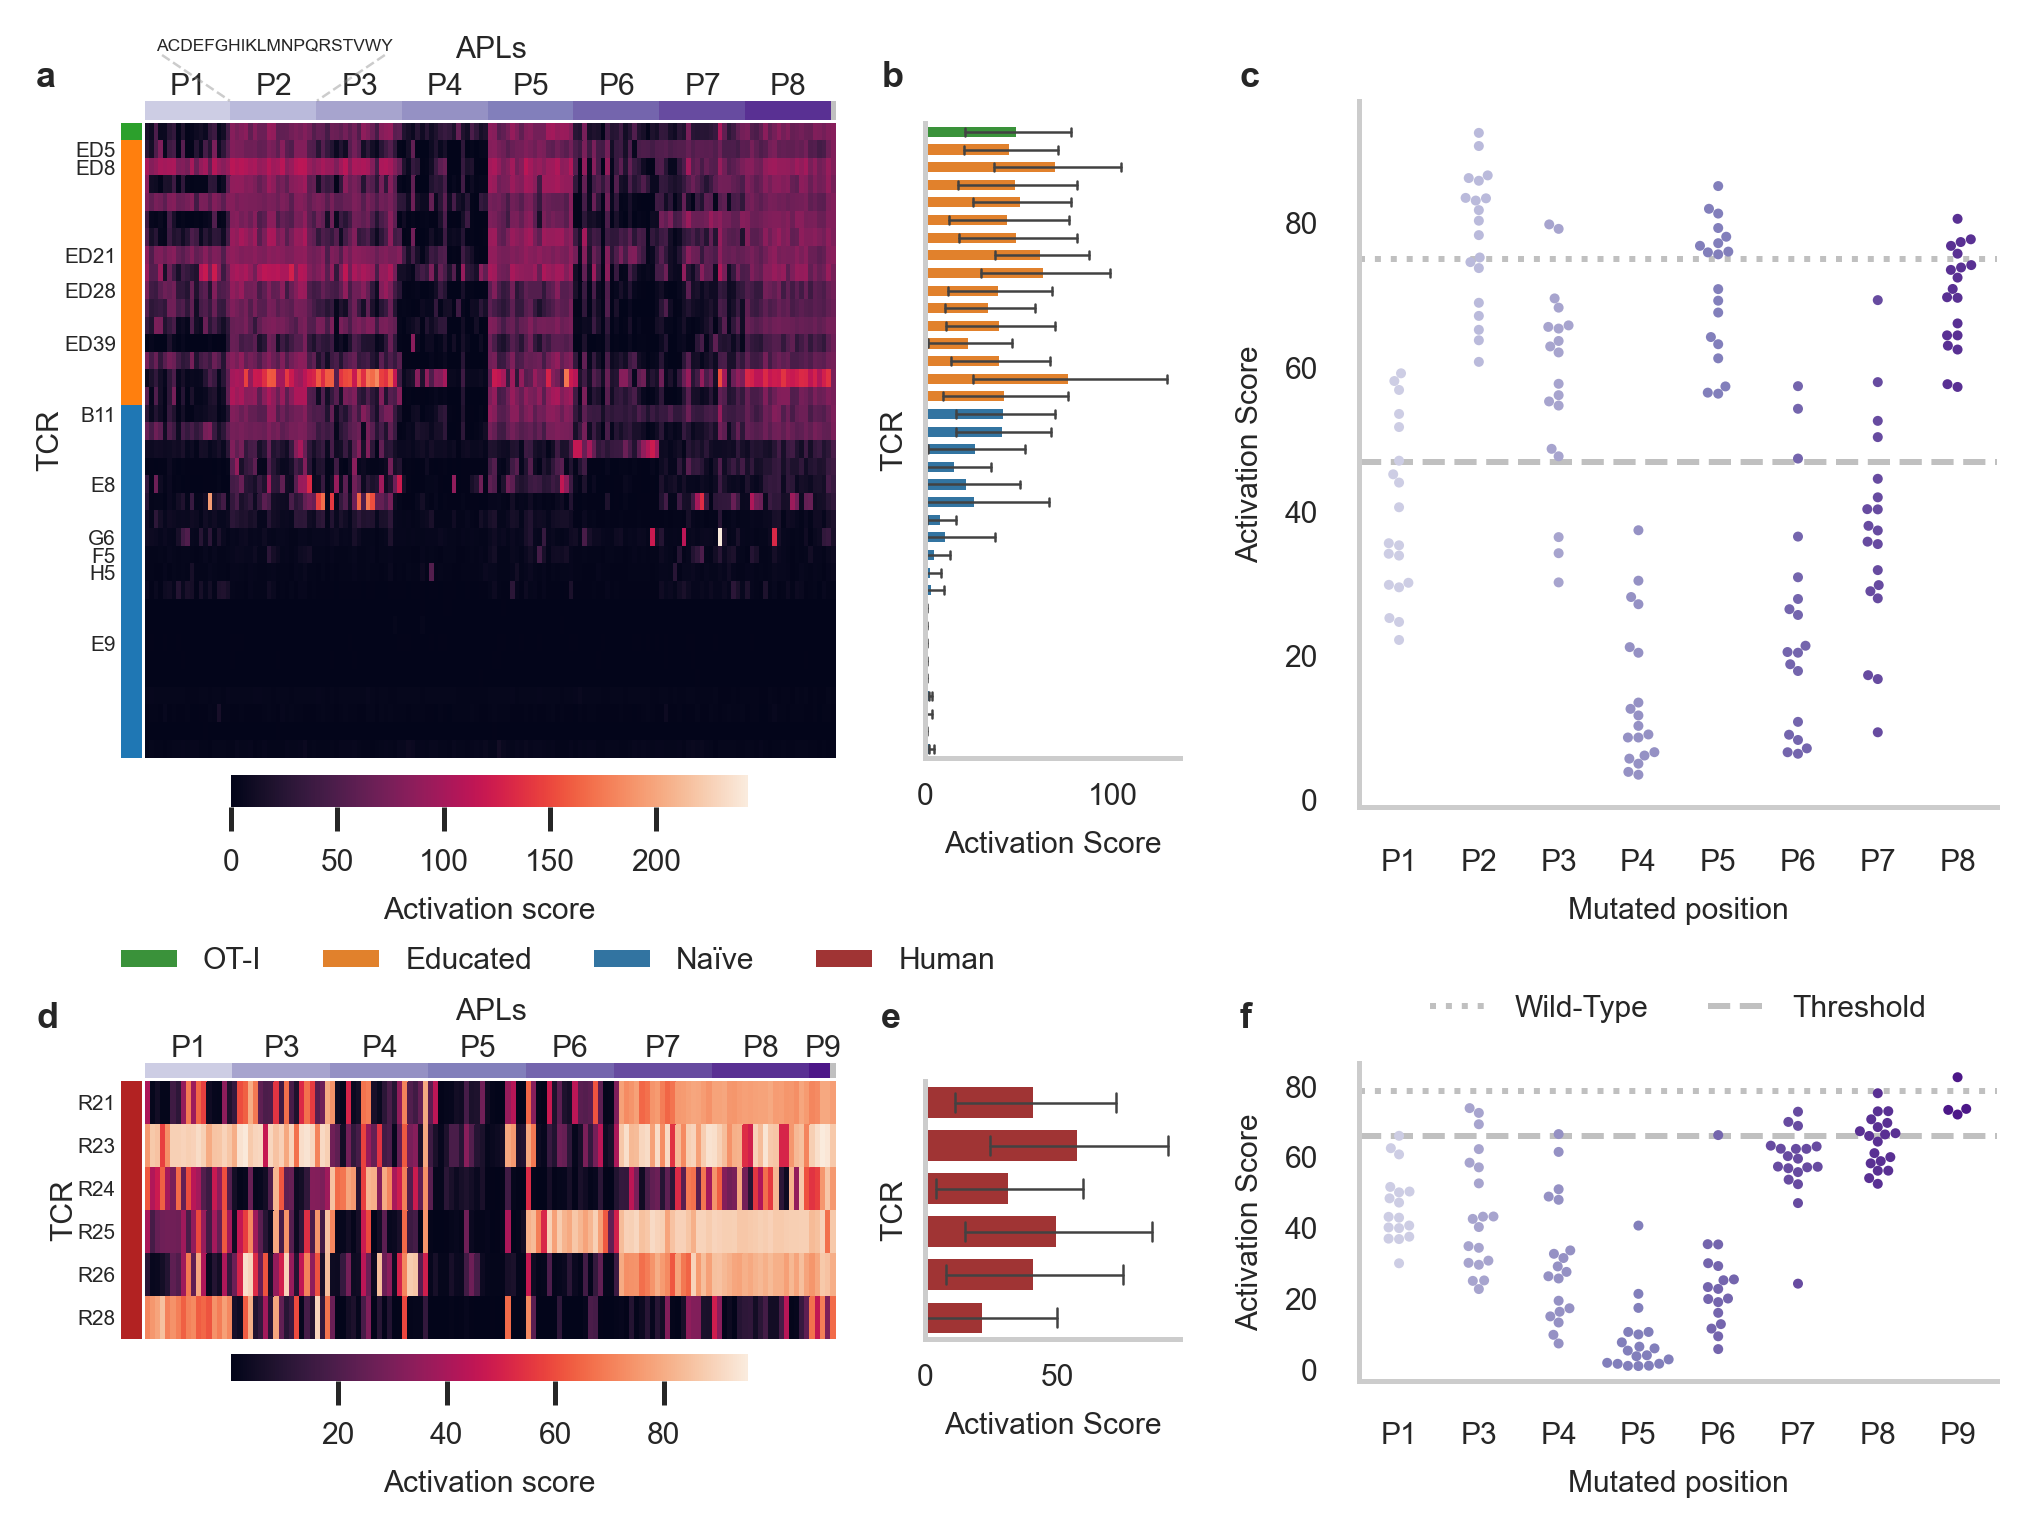

In [17]:
# a b 
# a c

# d e
# d f

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.7), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_123456'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 0.45],
    width_ratios=[1],
    #wspace=0.1,
    hspace=0.5,
)

gridspecs['gs_123'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123456'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1, ],
    width_ratios=[2, 5],
    wspace=0.4,
    #hspace=0.25,
)

gridspecs['gs_456'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123456'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_56'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_456'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 5],
    wspace=0.4,
    #hspace=0.25,
)

#axes['ax_a'] = fig.add_subplot(gridspecs['gs_123'][0])
#axes['ax_b'] = fig.add_subplot(gridspecs['gs_23'][0])
axes['ax_c'] = fig.add_subplot(gridspecs['gs_23'][1])

#axes['ax_d'] = fig.add_subplot(gridspecs['gs_456'][0])
#axes['ax_e'] = fig.add_subplot(gridspecs['gs_56'][0])
axes['ax_f'] = fig.add_subplot(gridspecs['gs_56'][1])

plot_activation_heatmap(data_mice_norm, gridspecs['gs_123'][0], fig)
axes['ax_b'] = plot_tcrs_averaged(data_mice_norm, gridspecs['gs_23'][0], fig=fig)
plot_epitopes(data_mice_norm, axes['ax_c'])

plot_activation_heatmap(data_human_norm, gridspecs['gs_456'][0], fig, yscale=2)
axes['ax_e'] = plot_tcrs_averaged(data_human_norm, gridspecs['gs_56'][0], yscale=2, fig=fig)
plot_epitopes(data_human_norm, axes['ax_f'], base_epitope='VPSVWRSSL', threshold=66.09, do_legend=True)

plot_tcr_legend([axes['ax_b'], axes['ax_e']], axes['ax_e'])

fig.text(0.09, 0.888, 'a', size='large', weight='bold')
fig.text(0.439, 0.888, 'b', size='large', weight='bold')
fig.text(0.587, 0.888, 'c', size='large', weight='bold')
fig.text(0.09, 0.333, 'd', size='large', weight='bold')
fig.text(0.439, 0.333, 'e', size='large', weight='bold')
fig.text(0.587, 0.333, 'f', size='large', weight='bold')

fig.text(0.1395, 0.91, 'ACDEFGHIKLMNPQRSTVWY', size='xx-small')
line_left = mpl.lines.Line2D([0.142, 0.17], [0.907, 0.88], linestyle='dashed', linewidth=0.5, color='gray', alpha=0.4)
line_right = mpl.lines.Line2D([0.234, 0.206], [0.907, 0.88], linestyle='dashed', linewidth=0.5, color='gray', alpha=0.4)
fig.add_artist(line_left)
fig.add_artist(line_right)

fig.tight_layout()
fig.savefig('figures/manuscript_fig2_data.pdf', dpi=DPI, bbox_inches='tight')


## Sup. X

<ipython-input-15-bc986ab9a9a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Activation'] = np.mean(data.values, axis=1)
<ipython-input-18-e1d91cf4f7a9>:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


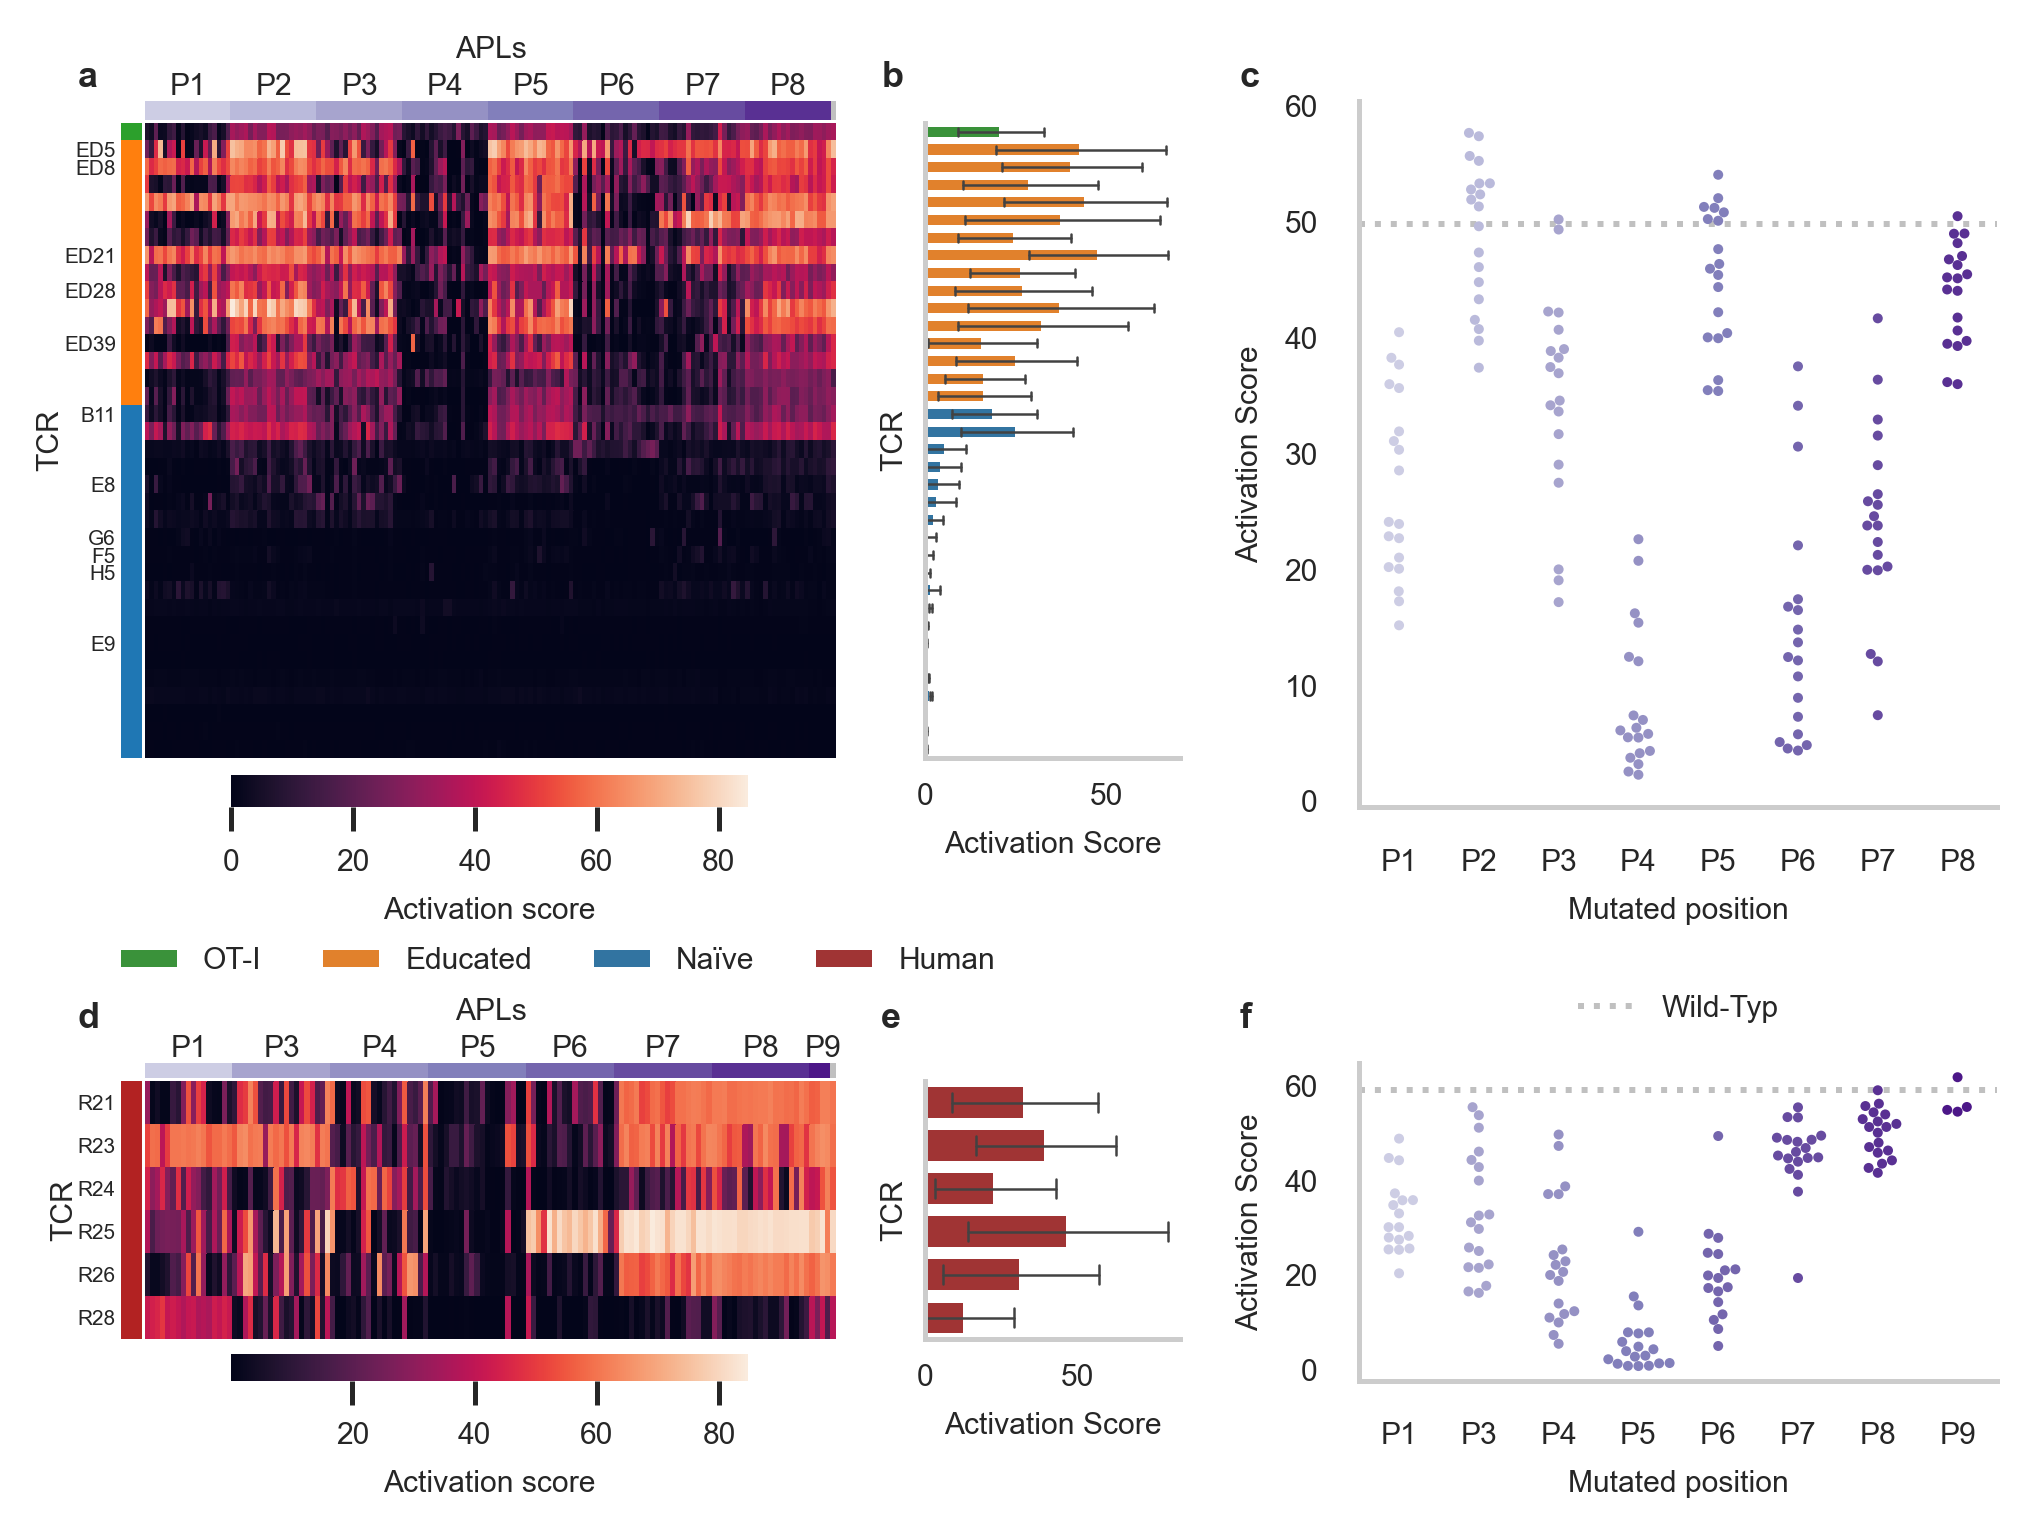

In [18]:
# a b 
# a c

# d e
# d f

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.7), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_123456'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 0.45],
    width_ratios=[1],
    #wspace=0.1,
    hspace=0.5,
)

gridspecs['gs_123'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123456'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1, ],
    width_ratios=[2, 5],
    wspace=0.4,
    #hspace=0.25,
)

gridspecs['gs_456'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123456'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_56'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_456'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 5],
    wspace=0.4,
    #hspace=0.25,
)

#axes['ax_a'] = fig.add_subplot(gridspecs['gs_123'][0])
#axes['ax_b'] = fig.add_subplot(gridspecs['gs_23'][0])
axes['ax_c'] = fig.add_subplot(gridspecs['gs_23'][1])

#axes['ax_d'] = fig.add_subplot(gridspecs['gs_456'][0])
#axes['ax_e'] = fig.add_subplot(gridspecs['gs_56'][0])
axes['ax_f'] = fig.add_subplot(gridspecs['gs_56'][1])

plot_activation_heatmap(data_mice_unnorm, gridspecs['gs_123'][0], fig)
axes['ax_b'] = plot_tcrs_averaged(data_mice_unnorm, gridspecs['gs_23'][0], fig=fig)
plot_epitopes(data_mice_unnorm, axes['ax_c'], threshold=None)

plot_activation_heatmap(data_human_unnorm, gridspecs['gs_456'][0], fig, yscale=2)
axes['ax_e'] = plot_tcrs_averaged(data_human_unnorm, gridspecs['gs_56'][0], yscale=2, fig=fig)
plot_epitopes(data_human_unnorm, axes['ax_f'], base_epitope='VPSVWRSSL', threshold=None, do_legend=True)

plot_tcr_legend([axes['ax_b'], axes['ax_e']], axes['ax_e'])

fig.text(0.107, 0.888, 'a', size='large', weight='bold')
fig.text(0.439, 0.888, 'b', size='large', weight='bold')
fig.text(0.587, 0.888, 'c', size='large', weight='bold')
fig.text(0.107, 0.333, 'd', size='large', weight='bold')
fig.text(0.439, 0.333, 'e', size='large', weight='bold')
fig.text(0.587, 0.333, 'f', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_s2_data_unnormalized.pdf', dpi=DPI, bbox_inches='tight')


## Paper numbers

In [19]:
(data_mice_norm > 46.9).sum()

OTI         85
Ed5         93
Ed8        118
Ed9         85
Ed10       103
Ed16-1      88
Ed16-30     78
Ed21       122
Ed23       104
Ed28        68
Ed31        57
Ed33        77
Ed39        32
Ed40        71
Ed45       101
Ed46        76
B11         70
B15         73
B3          23
F4          14
E8          24
B13         30
H6           0
G6           5
F5           1
H5           1
B2           0
B6           0
B5           0
E9           0
E4           0
G2           0
B16          0
B14          0
B7           0
B10          0
dtype: int64

In [20]:
(data_human_norm[:-1] > 66.09).sum()

R21    50
R23    75
R24    22
R25    62
R26    50
R28    20
dtype: int64

In [21]:
df_tmp = (data_human_norm>66.09)
df_tmp['pos'] = df_tmp.index.str[0]
df_tmp.groupby('pos').sum()

,R21,R23,R24,R25,R26,R28
pos,,,,,,
0,1,1,1,1,1,1
1,1,16,0,0,2,13
3,5,18,1,5,5,4
4,5,1,10,2,4,0
5,0,2,0,0,0,0
6,0,2,0,14,0,1
7,16,17,3,18,16,0
8,19,15,6,19,19,0
9,4,4,2,4,4,2
